In [68]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
#import ngauge
#from ngauge import Neuron
from skimage.io import*
from skimage.morphology import binary_dilation, ball,cube
import mat73
import tifffile as tiff 
#import neurom 
sns.set_context('paper')
sns.set_style('ticks')
plt.style.use("dark_background")
#matplotlib.use('TkAgg')

In [32]:
# For processing the SWC generated from Imaris
def read_swc(file_path):
    """Read coordinates and radii from an SWC file."""
    swc_data = pd.read_csv(file_path, delim_whitespace=True, comment='#', 
                           names=['n', 'type', 'x', 'y', 'z', 'r', 'parent'])
    print(f'Swc file {file_path} has {swc_data.shape[0]} rows and {swc_data.shape[1]} columns')
    return swc_data[['x', 'y', 'z']].values, swc_data['r'].values# pr

def add_to_binary_image(binary_image, coordinates, radii):
    """Mark points in the binary image based on coordinates and dilate them with specific radii."""
    for (x, y, z), radius in zip(coordinates, radii):
        if 0 <= x < binary_image.shape[2] and 0 <= y < binary_image.shape[1] and 0 <= z < binary_image.shape[0]:
            # Adjust the dilation size based on the radius, ensuring it is at least 1
            dilation_size = max(1, int(radius/2))
            selem = cube(dilation_size)
            # Calculate the region to apply dilation
            z_min, z_max = max(0, int(z) - dilation_size), min(binary_image.shape[0], int(z) + dilation_size + 1)
            y_min, y_max = max(0, int(y) - dilation_size), min(binary_image.shape[1], int(y) + dilation_size + 1)
            x_min, x_max = max(0, int(x) - dilation_size), min(binary_image.shape[2], int(x) + dilation_size + 1)
            # Apply dilation only within the specified region to save computation
            binary_image[z_min:z_max, y_min:y_max, x_min:x_max] |= binary_dilation(binary_image[z_min:z_max, y_min:y_max, x_min:x_max] == 0, selem)
            #apply dilation to the whole image
            #binary_image |= binary_dilation(binary_image == 0, selem)
    return binary_image

def create_3d_binary_image(swc_files, image_size):
    """Create a 3D binary image from multiple SWC files, dilating based on point-specific radii."""
    binary_image = np.zeros(image_size, dtype=np.uint8)
    for file_path in swc_files:
        coordinates, radii = read_swc(file_path)
        add_to_binary_image(binary_image, coordinates, radii)
    return binary_image

In [33]:
# For processing MAT files
def process_mat(mat_file):
    mat_data = mat73.loadmat(mat_file)
    efpxTrace = mat_data['efPxTrace']
    points = efpxTrace['Points']
    diamters = efpxTrace['Diameter']
    return points, diamters

def mat_df(mat_file):
    points, diamters = process_mat(mat_file)
    points = np.concatenate(points)
    radius = []
    for i in range(len(diamters)):
        radius.append(diamters[i]/2)
    radius = np.concatenate(radius)
    df = pd.DataFrame(points, columns=['x', 'y', 'z'])
    df['r'] = radius
    return df

def create_mat_binary_image(mat_file, image_size):
    """Create a 3D binary image from a mat file, dilating based on point-specific radii."""
    binary_image = np.zeros(image_size, dtype=np.uint8)
    df = mat_df(mat_file)
    coordinates = df[['x', 'y', 'z']].values
    radii = df['r'].values
    add_to_binary_image(binary_image, coordinates, radii)
    return binary_image

In [34]:
img_size = (97, 2844, 2835) # real image size 

In [35]:
imaris_bin = create_3d_binary_image(glob.glob('auto_trace.swc'), img_size)

Swc file auto_trace.swc has 59884 rows and 7 columns


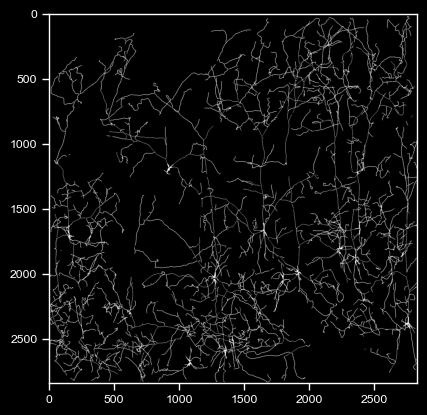

In [36]:
plt.imshow(imaris_bin.max(axis=0), cmap='gray')

In [37]:
qdye_bin = create_mat_binary_image('AfterClustering.mat', img_size)

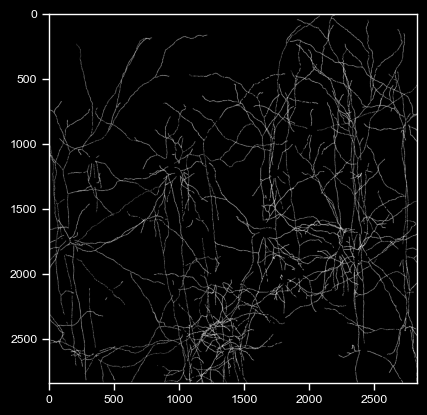

In [38]:
plt.imshow(qdye_bin.max(axis=0), cmap='gray')

In [39]:
gt_bin = create_mat_binary_image('ProcessedTraces_Manual.mat', img_size)

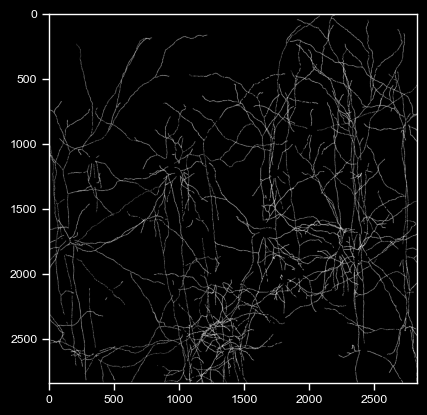

In [40]:
plt.imshow(gt_bin.max(axis=0), cmap='gray')

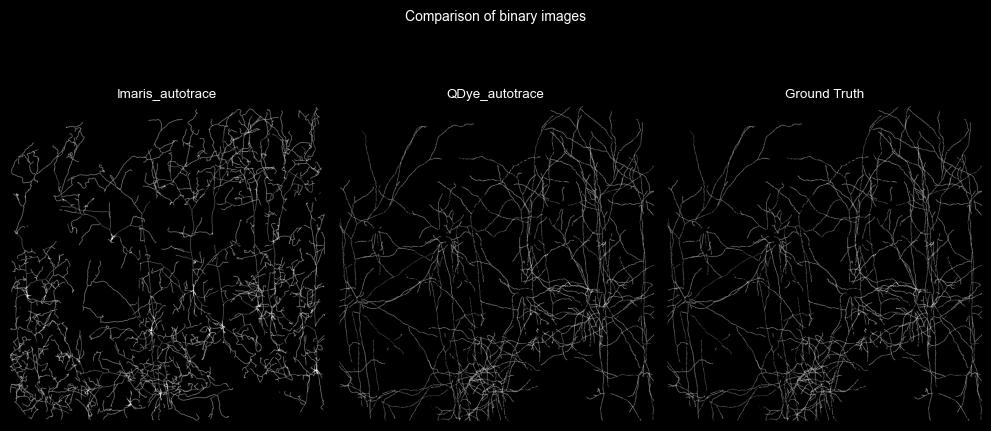

In [41]:
fig,ax = plt.subplots(1,3,figsize=(10,5))
fig.suptitle('Comparison of binary images',fontsize=10)
ax[0].imshow(imaris_bin.max(axis=0), cmap='gray')
ax[0].set_title('Imaris_autotrace')
ax[1].imshow(qdye_bin.max(axis=0), cmap='gray')
ax[1].set_title('QDye_autotrace')
ax[2].imshow(gt_bin.max(axis=0), cmap='gray')
ax[2].set_title('Ground Truth')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.tight_layout()
plt.show();

In [42]:
#calculate IoU
def IoU(gt, pred):
    intersection = np.logical_and(gt, pred)
    union = np.logical_or(gt, pred)
    iou = intersection.sum() / union.sum()
    return intersection, union, iou

In [43]:
imaris_intersect, imaris_union, imaris_iou = IoU(gt_bin, imaris_bin)
qdye_intersect, qdye_union, qdye_iou = IoU(gt_bin, qdye_bin)
imr_qdye_intersect, imr_qdye_union, imr_qdye_iou = IoU(imaris_bin, qdye_bin)

In [44]:
print(f'IoU between Imaris and QDye: {imr_qdye_iou:.2f}')
print(f'IoU between Imaris and GT: {imaris_iou:.2f}')
print(f'IoU between QDye and GT: {qdye_iou:.2f}')

IoU between Imaris and QDye: 0.06
IoU between Imaris and GT: 0.06
IoU between QDye and GT: 1.00


In [50]:
from matplotlib.colors import ListedColormap
num_colors = 256
pure_red  =ListedColormap(np.c_[np.linspace(0,1,num_colors), np.zeros(num_colors), np.zeros(num_colors)])
pure_green = ListedColormap(np.c_[np.zeros(num_colors), np.linspace(0,1,num_colors), np.zeros(num_colors)])
pure_magenta = ListedColormap(np.c_[np.linspace(0,1,num_colors), np.zeros(num_colors), np.linspace(0,1,num_colors)])
#magenta+green



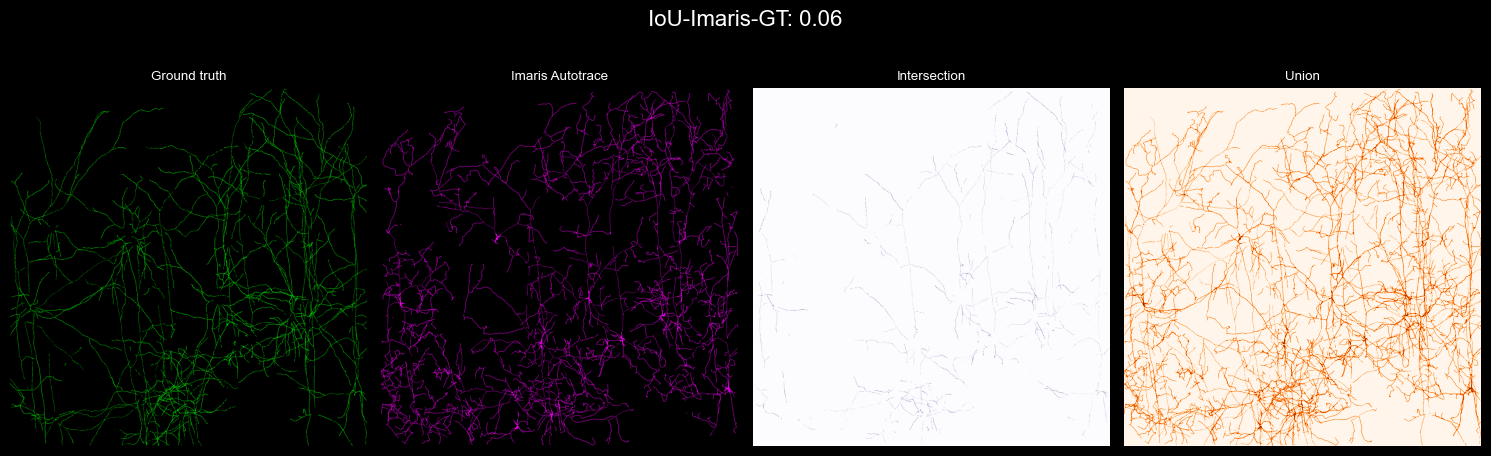

In [54]:
plt.figure(figsize=(15, 5))
#plt.style.use("dark_background")

plt.subplot(1, 4, 1)
plt.imshow(gt_bin.max(axis=0), cmap=pure_green)
plt.title('Ground truth')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imaris_bin.max(axis=0), cmap=pure_magenta)
plt.title('Imaris Autotrace')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imaris_intersect.max(axis=0), cmap='Purples')
plt.title('Intersection')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imaris_union.max(axis=0), cmap='Oranges')
plt.title('Union')
plt.axis('off')

plt.suptitle(f'IoU-Imaris-GT: {imaris_iou:.2f}', fontsize=16)
plt.tight_layout()
plt.show();

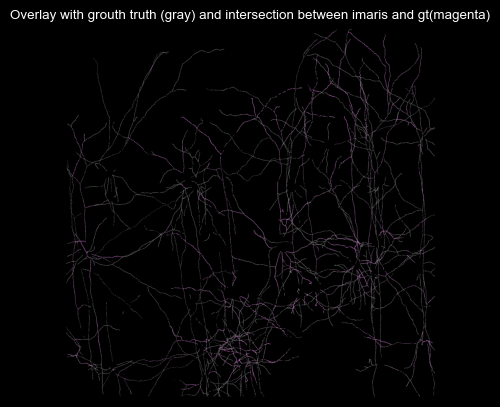

In [67]:
#plt.imshow(gt_bin.max(axis=0), cmap=pure_green)
plt.imshow(imaris_intersect.max(axis=0), cmap=pure_magenta)
plt.imshow(gt_bin.max(axis=0), cmap='gray', alpha=0.5)
plt.axis('off')
plt.title('Overlay with grouth truth (gray) and intersection between imaris and gt(magenta)')
plt.show();